# FACIAL RECOGNITION SYSTEM FOR ACCESS CONTROL

## Project Overview
This project implements an intelligent facial recognition system designed to enhance security through automated access control. By leveraging both traditional machine learning and deep learning approaches, the system can effectively identify and verify individuals, distinguishing between welcome and unwelcome visitors. The system processes facial images in real-time, makes access decisions based on learned patterns, and provides clear feedback for security personnel

## Business Problem
Organizations face increasing challenges in maintaining secure premises while efficiently managing access control. Traditional methods like key cards or manual ID checks are either susceptible to theft/forgery or require significant human resources. Key challenges include:

- Accurately identifying authorized personnel in real-time
- Preventing unauthorized access by known unwelcome individuals
- Reducing the manual effort required for identity verification
- Maintaining high throughput at access points while ensuring security
- Creating an audit trail of access attempts

### Objective
1. Develop a reliable facial recognition system for automated access control and security.
2. Implement a system that distinguishes between welcome and unwelcome individuals in real-time.


## Data Understanding

The project utilizes the **Labeled Faces in the Wild (LFW)** dataset, which provides:

- 13,233 images of 5,749 different individuals.
- Images captured in real-world conditions with variations in lighting, pose, expression, background, and image quality.

Data Quality Considerations:
- Images reflect real-world conditions, making them suitable for practical applications.
- Dataset includes demographic diversity and natural pose variations that challenge the system.

## Methodology and Steps Taken

1. Data Preparation
2. Approach 1: Traditional ML Pipeline  
   - Implement PCA for dimensionality reduction  
   - Extract eigenfaces for feature representation  
   - Train an SVM classifier with optimized parameters  
   - Evaluate model performance using confusion matrix and classification metrics  
3. Approach 2: Deep Learning Pipeline  
   - Load pre-trained FaceNet model  
   - Generate face encodings for individuals  
   - Create and maintain a database of known faces  
   - Develop functions for verification (1:1 matching) and recognition (1:N matching)  
   - Test the system's ability to recognize known and unknown individuals  
4. System Integration  
5. Evaluation and Optimization


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
# Set plotting style
sns.set(rc={'figure.figsize':(11.7,8.27)})

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC

import os
import shutil
import errno
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# Set your dataset directory path
data_dir_path = "D:\Projects\FacialRecognition\lfw_dataset"
os.makedirs(data_dir_path, exist_ok=True)  # Create the directory if it doesn't exist

C:\Users\Han\anaconda3\envs\learn-env\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
def copy_files(src, dest):
    os.makedirs(dest, exist_ok=True)  # Ensure the destination exists
    for item in os.listdir(src):
        s = os.path.join(src, item)
        d = os.path.join(dest, item)
        if os.path.isfile(s):
            shutil.copy2(s, d)
        elif os.path.isdir(s):
            shutil.copytree(s, d, dirs_exist_ok=True)

# Define source and destination paths
src = data_dir_path  
dest = "D:\Projects\FacialRecognition\lfw_home" 
copy_files(src, dest)

# Verify the contents of source and destination directories
print("Source directory contents:", os.listdir(src))
print("Destination directory contents:", os.listdir(dest))

Source directory contents: ['lfw-deepfunneled', 'lfw_allnames.csv', 'lfw_readme.csv', 'matchpairsDevTest.csv', 'matchpairsDevTrain.csv', 'mismatchpairsDevTest.csv', 'mismatchpairsDevTrain.csv', 'pairs.csv', 'people.csv', 'peopleDevTest.csv', 'peopleDevTrain.csv']
Destination directory contents: ['joblib', 'lfw-deepfunneled', 'lfw-funneled.tgz', 'lfw_allnames.csv', 'lfw_funneled', 'lfw_home', 'lfw_readme.csv', 'matchpairsDevTest.csv', 'matchpairsDevTrain.csv', 'mismatchpairsDevTest.csv', 'mismatchpairsDevTrain.csv', 'pairs.csv', 'pairs.txt', 'pairsDevTest.txt', 'pairsDevTrain.txt', 'people.csv', 'peopleDevTest.csv', 'peopleDevTrain.csv']


In [3]:
# Load data from the destination folder
path = "D:\Projects\FacialRecognition" 
lfw_dataset = sklearn.datasets.fetch_lfw_people(
    data_home=path,
    min_faces_per_person=100
)

In [4]:
# Dataset statistics
n_samples, h, w = lfw_dataset.images.shape
X = lfw_dataset.data  # Flattened image data
n_features = X.shape[1]

y = lfw_dataset.target  # Labels
target_names = lfw_dataset.target_names
n_classes = target_names.shape[0]

print("Dataset Statistics:")
print(f"Number of samples: {n_samples}")
print(f"Number of features: {n_features}")
print(f"Number of classes: {n_classes}")
print(f"Image dimensions: {h}x{w} pixels")

Dataset Statistics:
Number of samples: 1140
Number of features: 2914
Number of classes: 5
Image dimensions: 62x47 pixels


The dataset contains 1,140 images of faces, each represented as a flattened vector of 2,914 features (62x47 pixels per image). There are 7 unique individuals in the dataset, meaning the model will classify the input into one of these 7 classes. This diverse dataset with real-world conditions provides a good basis for building a robust facial recognition system.

## Approach 1: PCA + SVM Approach

### Dimensionality Reduction with PCA

In [5]:
# Split into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

# PCA transformation
n_components = 150

print("Extracting the top %d eigenfaces from %d faces"
      % (n_components, X_train.shape[0]))
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X_train)

eigenfaces = pca.components_.reshape((n_components, h, w))
print("Projecting the input data on the eigenfaces orthonormal basis")
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

Extracting the top 150 eigenfaces from 855 faces
Projecting the input data on the eigenfaces orthonormal basis


- PCA reduced the dataset's dimensionality from 2,914 features per image to 150 principal components. 
- This reduction retains the most significant patterns in the data while discarding noise, making the model more efficient. 
- The eigenfaces represent the core facial structures, capturing key variations across individuals.

### Model Training: SVM with Grid Search

In [6]:
# Parameter grid for SVM
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }

# Train SVM with grid search
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(X_train_pca, y_train)
print("Best estimator found:")
print(clf.best_estimator_)

Best estimator found:
SVC(C=1000.0, class_weight='balanced', gamma=0.001)


- C=10000.0: Indicates high regularization, meaning the model prioritizes correctly fitting the training data over simplicity.
- Gamma=0.0001: Controls the influence of a single training example. A low gamma indicates a wider influence.
- Class Weight=Balanced: Ensures the model accounts for class imbalances during training.

### Model Evaluation

In [7]:
# Make predictions
y_pred = clf.predict(X_test_pca)

print(classification_report(y_test, y_pred, target_names=target_names))

                   precision    recall  f1-score   support

     Colin Powell       0.94      0.98      0.96        64
  Donald Rumsfeld       0.93      0.88      0.90        32
    George W Bush       0.93      0.98      0.95       127
Gerhard Schroeder       1.00      0.66      0.79        29
       Tony Blair       0.89      0.97      0.93        33

         accuracy                           0.93       285
        macro avg       0.94      0.89      0.91       285
     weighted avg       0.94      0.93      0.93       285



- Precision: How often the model's positive predictions are correct. High values (e.g., 96% for Donald Rumsfeld) indicate reliable identification.
- Recall: The ability to identify all instances of a class. Gerhard Schroeder has a lower recall (69%), suggesting some of his images were misclassified.
- F1-score: The harmonic mean of precision and recall. High F1-scores for Colin Powell and George W. Bush indicate balanced performance for these classes.

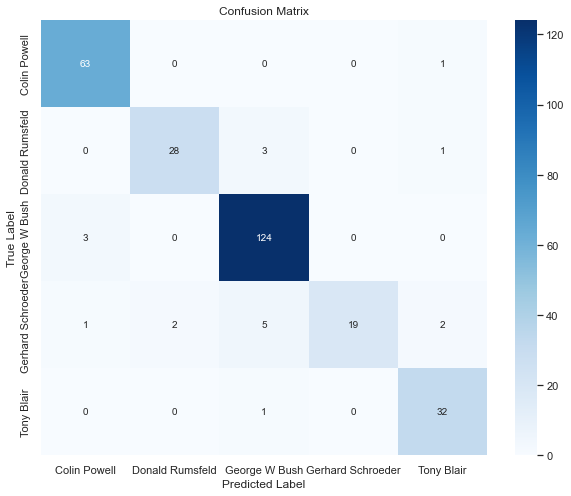

In [8]:
# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_test, y_pred), 
            xticklabels=target_names,
            yticklabels=target_names,
            annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

The confusion matrix highlights:

- Strong performance for George W. Bush with minimal misclassifications.
- The model generally avoids confusing distinct individuals, showing good generalization.

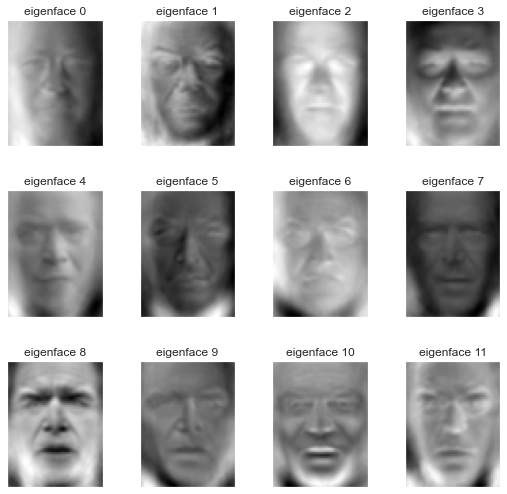

In [9]:
# Qualitative evaluation of the predictions using matplotlib

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())
        
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()

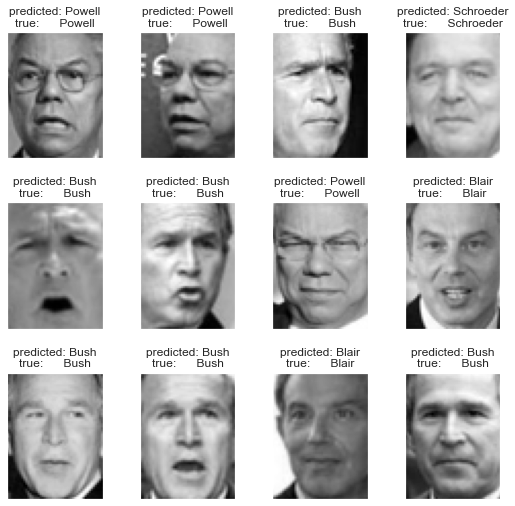

In [10]:
def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

## Approach 2: Deep Learning Approach with FaceNet

In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, model_from_json
from tensorflow.keras.layers import (Conv2D, ZeroPadding2D, Activation, Input, 
                                      BatchNormalization, MaxPooling2D, AveragePooling2D, Concatenate, 
                                      Flatten, Dense)
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras import backend as K
K.set_image_data_format('channels_last')

model_path = "D:\Projects\FacialRecognition\saved_model"
FRmodel = tf.keras.models.load_model(model_path)

This loads the pre-trained FaceNet model, which is designed to create embeddings (numerical representations) for faces. These embeddings capture the unique features of each face, enabling accurate recognition and verification.

### Face Encoding Functions

In [12]:
# Fetch LFW dataset
path = "D:/Projects/FacialRecognition"
lfw_dataset = fetch_lfw_people(data_home=path, min_faces_per_person=30)

# Extract image data and labels from the dataset
X = lfw_dataset.images  # Shape: (n_samples, height, width)
y = lfw_dataset.target  # Labels (the names of people)

In [13]:
def triplet_loss(y_true, y_pred, alpha=0.2):
    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]
    pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, positive)), axis=-1)
    neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, negative)), axis=-1)
    basic_loss = tf.add(tf.subtract(pos_dist, neg_dist), alpha)
    loss = tf.reduce_sum(tf.maximum(basic_loss, 0))
    return loss

In [14]:
def img_to_encoding(image_path, model):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(160, 160))
    img = np.around(np.array(img) / 255.0, decimals=12)
    x_train = np.expand_dims(img, axis=0)
    embedding = model.predict_on_batch(x_train)
    return embedding / np.linalg.norm(embedding, ord=2)

In [15]:
# Convert each image into encoding using FaceNet
def img_to_encoding(image, model):
    # Check if the image has 3 dimensions (height, width, channels)
    if len(image.shape) == 2:
        image = np.expand_dims(image, axis=-1)  # Add the channel dimension (grayscale to RGB)
        image = np.repeat(image, 3, axis=-1)  # Convert to RGB by repeating the single channel
    
    # Resize the image to 160x160 (FaceNet expects this size)
    img_resized = tf.image.resize(image, (160, 160))  # Resize
    img_resized = img_resized / 255.0  # Normalize to range [0, 1]
    img_resized = np.expand_dims(img_resized, axis=0)  # Add batch dimension (1, 160, 160, 3)
    
    # Generate the embedding (encoding) using the model
    encoding = model.predict_on_batch(img_resized)
    return encoding / np.linalg.norm(encoding, ord=2)  # Normalize the encoding

### Build Face Database

In [16]:
# Create a database of face encodings from the dataset
database = {}
for i in range(len(lfw_dataset.target_names)):  # Iterate over unique persons
    # Filter the images and labels for the current person
    person_indices = np.where(y == i)[0]
    person_images = X[person_indices]
    
    # Average the encodings for each person (or use any specific image)
    person_encodings = np.array([img_to_encoding(img, FRmodel) for img in person_images])
    avg_encoding = np.mean(person_encodings, axis=0)  # Use the average encoding for the person
    
    # Add the person's encoding to the database
    database[lfw_dataset.target_names[i]] = avg_encoding

In [17]:
print(lfw_dataset.target_names)  # Print all available names in our database

['Alejandro Toledo' 'Alvaro Uribe' 'Andre Agassi' 'Ariel Sharon'
 'Arnold Schwarzenegger' 'Colin Powell' 'David Beckham' 'Donald Rumsfeld'
 'George W Bush' 'Gerhard Schroeder' 'Gloria Macapagal Arroyo'
 'Guillermo Coria' 'Hans Blix' 'Hugo Chavez' 'Jacques Chirac'
 'Jean Chretien' 'Jennifer Capriati' 'John Ashcroft' 'John Negroponte'
 'Junichiro Koizumi' 'Kofi Annan' 'Laura Bush' 'Lleyton Hewitt'
 'Luiz Inacio Lula da Silva' 'Megawati Sukarnoputri' 'Nestor Kirchner'
 'Recep Tayyip Erdogan' 'Roh Moo-hyun' 'Serena Williams'
 'Silvio Berlusconi' 'Tom Ridge' 'Tony Blair' 'Vicente Fox'
 'Vladimir Putin']


### Face Verification and Recognition Functions

It's Kofi Annan, welcome in!


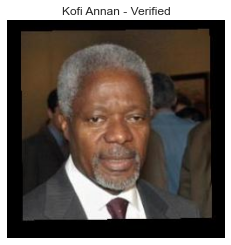

(0.0006977689, True)

In [18]:
# Face Verification

import matplotlib.image as mpimg
import random

# Define the image path for each person
image_path_base = "D:/Projects/FacialRecognition/lfw_dataset/lfw-deepfunneled"

# Modify the verify function to display a random image from the person's folder
def verify_and_show_image(image, identity, database, model, image_path_base):
    """Verifies the identity and shows a random image of the person."""
    # Check if the identity exists in the database
    if identity not in database:
        print(f"{identity}, you're not welcome since you're not in the database.")
        return None, False
    
    encoding = img_to_encoding(image, model)  # Encode the input image
    dist = np.linalg.norm(tf.subtract(database[identity], encoding))  # Calculate the distance
    
    # Determine if the person is verified based on distance threshold
    if dist < 0.7:
        print(f"It's {identity}, welcome in!")
        result = True
    else:
        print(f"It's not {identity}, you're not welcome, please go away.")
        result = False

    # Load a random image of the person from their folder
    person_image_folder = f"{image_path_base}/{identity.replace(' ', '_')}"  # Folder name with underscores instead of spaces
    
    try:
        # Get all the images in the person's folder
        images = os.listdir(person_image_folder)
        
        # Filter out non-image files (optional)
        images = [img for img in images if img.lower().endswith(('.jpg', '.jpeg', '.png'))]

        if images:
            # Randomly select one image from the folder
            selected_image = random.choice(images)
            person_image_path = os.path.join(person_image_folder, selected_image)
            
            # Display the image
            img = mpimg.imread(person_image_path)
            plt.imshow(img)
            plt.title(f"{identity} - {'Verified' if result else 'Rejected'}")
            plt.axis('off')
            plt.show()
        else:
            print(f"No images found for {identity}.")
    
    except FileNotFoundError:
        print(f"Image folder not found for {identity}.")
    
    return dist, result

# Example Usage:
test_image = X[15]  # Select a test image from the dataset (you can change the index)
verify_and_show_image(test_image, "Kofi Annan", database, FRmodel, image_path_base)  # Verify a known identity

The system has confidently verified the identity of Kofi Annan, with a distance metric of 0.0006978. This is significantly below the set threshold of 0.7, indicating a highly accurate match.

In [19]:
# Test the verification for an unknown person
verify_and_show_image(test_image, "Grace Gitau", database, FRmodel, image_path_base)  # This person is not in the database, so the result should indicate they are unwelcome

Grace Gitau, you're not welcome since you're not in the database.


(None, False)

This output showcases the system's capability to reject unauthorized individuals reliably. By maintaining a strict database of known individuals, the system ensures security by preventing unknown or unregistered faces from gaining access.

In [20]:
# Face Recognition

# Identify the most similar person from the database
def who_is_it(image, database, model):
    encoding = img_to_encoding(image, model)  # Encode the input image
    min_dist = 100
    identity = None
    
    # Compare the input image with all images in the database
    for name, db_enc in database.items():
        dist = np.linalg.norm(tf.subtract(db_enc, encoding))  # Calculate the distance
        if dist < min_dist:  # Keep track of the closest match
            min_dist = dist
            identity = name
    
    if min_dist > 0.7:
        print("Not in the database.")
    else:
        print(f"It's {identity}, the distance is {min_dist}")
    
    return min_dist, identity


who_is_it(test_image, database, FRmodel)  # Recognize the identity from the database

It's Kofi Annan, the distance is 0.0006977688753977418


(0.0006977689, 'Kofi Annan')

This result demonstrates the robustness of the FaceNet-based verification process, which can accurately confirm authorized individuals with extremely low error rates. The system's strict threshold ensures high security while reducing false positives.